In [1]:
%matplotlib widget

## Python Package Imports

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm
from IPython.display import display, Math, clear_output

import sympy  #Sympy1.2 is from conda-forge: [sudo conda install -c conda-forge sympy]
from sympy import *
from sympy.physics.vector import ReferenceFrame, CoordinateSym
from sympy.vector import CoordSys3D, divergence, curl

import ipyvolume as ipv
import time
from ipywidgets import Output

import helpers

np.seterr(divide='ignore', invalid='ignore');

### Check versions of important packages 
(Need Sympy Version >=1.2 from conda-forge)

In [3]:
print('Ipyvolume version = {}'.format(ipv.__version__))
print('Sympy version = {}'.format(sympy.__version__))
print('IPyVolume version = {}'.format(ipv.__version__))

Ipyvolume version = 0.4.6
Sympy version = 1.2
IPyVolume version = 0.4.6


## Let's check that plotting and the plotting widget are correctly installed

The plot may be hidden with only a "power" button in the upper-right. Click this button to toggle the display of the plot. Note the widgets below the plot that allow you to: 1) 'home' the view; 2) toggle the view forward or backwards; 3) pan the axes; 4) zoom to a rectangle and; 5) save/download the figure.

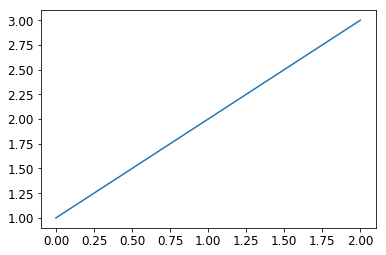

In [4]:
init_printing()
plt.figure()
plt.plot([1,2,3])
plt.show()

## Sympy is a Python module for symbolic mathematics. 

#### The basics of vectors and fields in Sympy are:
1. Unit vectors are indicated by a . (For example, R.x is the unit vector in the x direction). 
2. Scalars are indicated by [] (For example, R[0] is x)

#### Sympy functions and capabilities to be aware of:
From the [**Sympy.vector**](http://docs.sympy.org/latest/modules/vector/index.html) module: 

Vector calculus examples specific to electrodynamics include:

1. [divergence](http://docs.sympy.org/latest/modules/vector/api/vectorfunctions.html#divergence)
2. [curl](http://docs.sympy.org/latest/modules/vector/api/vectorfunctions.html#curl)
3. [gradient](http://docs.sympy.org/latest/modules/vector/api/vectorfunctions.html#gradient)
4. [scalar_potential](http://docs.sympy.org/latest/modules/vector/api/vectorfunctions.html#scalar_potential)
5. [scalar_potential_difference](http://docs.sympy.org/latest/modules/vector/api/vectorfunctions.html#potential_difference)
6. [is_conservative](http://docs.sympy.org/latest/modules/vector/api/vectorfunctions.html#is_conservative)

#### Sympy can evaluate integrals and derivates symbolically and numerically:

1. [integrals](http://docs.sympy.org/latest/tutorial/calculus.html?highlight=derivatives#integrals)
2. [derivatives](http://docs.sympy.org/latest/tutorial/calculus.html?highlight=derivatives#derivatives)

#### Sympy supports non-Cartesian coordinate systems:
1. The coordinate system can be represented in non-Cartesian systems, such as spherical or cylindrical:  
`A = CoordSys3D('A', transformation='spherical')  # (transformation parameter requires Sympy 1.2)`
[coordinate transformations](http://docs.sympy.org/latest/modules/vector/coordsys.html#transforming-new-system)

## Symbolic Calculation of the Divergence
### Be sure to try these steps by hand 

**Step 1.** Initialize the coordinate system and the vector field; display the equation for the vector field. Note that the subscript **A** simply represents the coordinate system; awkward, but don't let it throw you.

In [5]:
A = CoordSys3D('A')  # initialize a 3D coordinate system 
F = A.x*A.y*A.z*(A.i + A.j + A.k)
display(Math(r'\textbf{F} = ' + latex(F)))

<IPython.core.display.Math object>

**Step 2.** Symbolically calculate the divergence

In [6]:
div = divergence(F)
print('Divergence:')
display(Math(r'\nabla \cdot \textbf{F} = ' + latex(div)))

Divergence:


<IPython.core.display.Math object>

### Above we have the divergence of the vector field F  

### A Few Notes:
* The *vector field* has three vector components at each point in space (i.e. x,y,z)
* The divergence of the vector field is a *scalar field*. At each point in space there is only a single scalar value.

## Numerical Evaluation of the Divergence for Display

**Step 3.** Create a function from the symbolic divergence (to evaluate at any x,y,z point)

In [7]:
vars = symbols('A.x A.y A.z')  # this is to fix a lambdify "bug"
div_func = lambdify(vars, div.subs(dict(zip([A.x, A.y, A.z], vars))), modules='numpy')

**Step 4.** Create a field (i.e. x, y, z arrays) and evaluate the divergence over the field.
Note: the ordering of x,y,z combined with meshgrid is [not obvious](https://github.com/maartenbreddels/ipyvolume/issues/79)

In [8]:
x = np.linspace(0, 10, 41)
y = np.linspace(0, 10, 41)
z = np.linspace(0, 10, 41)
X, Y, Z = np.meshgrid(x,y,z, indexing='ij')
divergence_data = helpers.check_lambdify_out(div_func(X, Y, Z), X, Y, Z)

**Step 5.** First let's display a straight-forward scalar field. Displaying a 3D volume is challenging. 
* To see "inside" a 3D scalar field there must be a notion of transparency and opacity.
* The colormap is not obvious. For example, red is *not necessarily* the greatest value. 

In [9]:
V = np.zeros((128,128,128)) # our 3d array 128x128x128
# outer box
V[30:-30,30:-30,30:-30] = 0.75
V[35:-35,35:-35,35:-35] = 0.0
# inner box
V[50:-50,50:-50,50:-50] = 0.25
V[55:-55,55:-55,55:-55] = 0.0

# corner (near 0,0,0)
V[0:10, 0:10, 0:10] = 0.25
# corner (near 128,128,128)
V[-10:-1, -10:-1, -10:-1] = 0.75

ipv.volshow(V, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=1)

A Jupyter Widget

**Step 6.** Back to the divergence. Let's check a few points. Recall the expression:

In [10]:
display(Math(r'\nabla \cdot \textbf{F} = ' + latex(div)))

<IPython.core.display.Math object>

In [11]:
print('The size of this array is: {}'.format(np.shape(divergence_data)))

def my_func_eval(func,indx_x,indx_y,indx_z):
    display(Math(r'\nabla \cdot \textbf{F}' + '({},{},{}) = {}'.format(indx_x, indx_y, indx_z, func[indx_x, indx_y,indx_z])))
    return func[indx_x,indx_y,indx_z]

x = my_func_eval(divergence_data, 0, 0, 0);
x = my_func_eval(divergence_data, 0, 40, 40);
x = my_func_eval(divergence_data, 40, 0, 40);
x = my_func_eval(divergence_data, 40, 40, 0);
x = my_func_eval(divergence_data, 40, 40, 40);

The size of this array is: (41, 41, 41)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Step 7.** A now display the divergence

In [12]:
# plot a 3d figure 
ipv.figure()
ipv.volshow(divergence_data, opacity=0.03, level_width=20)
# ipv.view(azimuth = 115, elevation = 90)
ipv.show()

A Jupyter Widget

### We can also evaluate the function at specific points

In [13]:
def my_func_eval(func, x,y,z):
    print('  Function evaluated at point {},{},{} = {}'.format(x,y,z,func(x,y,z)))
    return func(x,y,z)

my_func_eval(div_func, 0,0,0);
my_func_eval(div_func, 10,10,10);

  Function evaluated at point 0,0,0 = 0
  Function evaluated at point 10,10,10 = 300


In [14]:
x = np.linspace(-10, 10, 10)
y = np.linspace(-10, 10, 10)
z = np.linspace(-10, 10, 10)
X, Y, Z = np.meshgrid(x,y,z, indexing='ij');
 
u,v,w = helpers.evaluate_field_components(A, F, X,Y,Z);

ipv.figure()
quiver = ipv.quickquiver(X.flatten(), Y.flatten(), Z.flatten(), u.flatten(), v.flatten(), w.flatten(), size=2);
ipv.show()

A.i
A.j
A.k


A Jupyter Widget

## Symbolic Calculation of the Gradient 

In [15]:
#define symbolic vars, function
x,y,z =sympy.symbols('x y z')
fun = x**2

# evaluate the gradient symbolically
gradfun = [sympy.diff(fun, var) for var in (x,y,z)]
print('Gradient of: {}'.format(fun))
print(gradfun)
print(np.shape(gradfun))

#turn into a bivariate lambda for numpy
numgradfun = sympy.lambdify([x,y,z], gradfun)

x = np.linspace(-10, 10, 41)
y = np.linspace(-10, 10, 41)
z = np.linspace(-10, 10, 41)
X, Y, Z = np.meshgrid(x,y,z, indexing='ij')

gradient_eval = sum(numgradfun(X, Y, Z))

print('{}, {}, {}'.format(np.shape(X),np.shape(Y),np.shape(Z)))
print(np.shape(gradient_eval))
print(numgradfun(1,1,2))
print(sum(numgradfun(1,1,2)))
ipv.figure()
ipv.volshow(gradient_eval.T, opacity=0.03, level_width=0.1, data_min=0, data_max=1)
ipv.view(azimuth = 115, elevation = 90)
ipv.show()

Gradient of: x**2
[2*x, 0, 0]
(3,)
(41, 41, 41), (41, 41, 41), (41, 41, 41)
(41, 41, 41)
[2, 0, 0]
2


A Jupyter Widget

In [16]:
### In Spherical coords? https://github.com/sympy/sympy/blob/master/examples/advanced/curvilinear_coordinates.py
## Or: http://docs.sympy.org/latest/modules/vector/coordsys.html?highlight=coordsys3d

In [17]:
A = CoordSys3D('A', transformation='spherical')  # the transformation parameter requires Sympy 1.2 
r, theta, phi, a, b, c = symbols('r theta phi a b c')

vec_field = a*A.r**2*A.i + c*cos(A.theta)/A.r*A.j + b * A.k 
div = divergence(vec_field)
pprint(div)
display(Math(r'{}'.format(latex(div))))

                 2                 2         
          - c⋅sin (A_theta) + c⋅cos (A_theta)
4⋅A_r⋅a + ───────────────────────────────────
                      2                      
                   A_r ⋅sin(A_theta)         


<IPython.core.display.Math object>

In [18]:
var("rho theta phi")
x_hat = Matrix([
    rho * sin(theta) * cos(phi),
    rho * sin(theta) * sin(phi),
    rho * cos(theta)])
x = Matrix([rho, theta, phi])

M = zeros(3, 3)
for i in range(3):
    for j in range(3):
        M[i, j] = x_hat[i].diff(x[j])

N = M.inv(method="ADJ")
one = sin(phi)**2*sin(theta)**2 - cos(phi)**2*cos(theta)**2 + \
        cos(phi)**2 + cos(theta)**2
one_simple = one.subs(sin(phi)**2, 1-cos(phi)**2).expand().simplify()
N.simplify()
# one_simple is equal to 1, but simplify() can't do this automatically yet:
N = N.subs(one, one_simple)

display(Math(r'J = {}'.format(latex(M))))
display(Math(r'inv(J) = {}'.format(latex(M))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

$$
a_1 = b_1 + c_1 \\
a_2 = b_2 + c_2 + d_2
$$

## Let's calculate the divergence of a function using sympy and visualize the result

In [19]:
# import numpy as np
# import matplotlib.pyplot as plt

# X,Y=np.meshgrid(np.arange(-10,11),np.arange(-10,11))
# graddat=numgradfun(X,Y)

# plt.quiver(X,Y,graddat[0],graddat[1])
# plt.show()

In [20]:
# R = ReferenceFrame('R')
# x,y,z = sympy.symbols('x y z')

# F = R[1]**2 * R[2] * R.x - R[0]*R[1] * R.y + R[2]**2 * R.z
# G = curl(F)  

# #turn into a bivariate lambda for numpy
# curl_fun = sympy.lambdify([x, y, z], G)

# fig = plt.figure()
# ax = fig.gca(projection='3d')

# X,Y,Z = np.meshgrid(np.arange(-0.8, 1, 0.2),
#                       np.arange(-0.8, 1, 0.2),
#                       np.arange(-0.8, 1, 0.8))
# curl_eval = numgradfun(X, Y, Z)

# ax.quiver(x, y, z, curl_eval[0], curl_eval[1], curl_eval[2], length=0.1)

# plt.show()

## Here we demonstrate a surface (or mesh or wireframe) plot. 
### The input data to a 3D surface plot is 3 vectors (i.e. x,y,z). These vectors define a surface; the surface is not a vector field, nor is it a scalar value defined at all points in space. 

In [21]:
# Create the data.
dphi, dtheta = np.pi/250.0, pi/250.0
[phi,theta] = np.mgrid[0:np.pi+dphi*1.5:dphi,0:2*np.pi+dtheta*1.5:dtheta]
m0 = 4; m1 = 3; m2 = 2; m3 = 3; m4 = 6; m5 = 2; m6 = 6; m7 = 4;
r = np.sin(m0*phi)**m1 + np.cos(m2*phi)**m3 + np.sin(m4*theta)**m5 + np.cos(m6*theta)**m7
x = r*np.sin(phi)*np.cos(theta)
y = r*np.cos(phi)
z = r*np.sin(phi)*np.sin(theta)

# And surface/mesh plots, showing surfaces or wireframes.
ipv.clear()
ipv.figure()
ipv.plot_mesh(x, y, z, wireframe=False)
ipv.squarelim()
ipv.show()

A Jupyter Widget

## Here we demonstrate a quiver plot, which shows a vector at each position
### The input data to a 3D quiver plot is: 
1. a sequence of three vectors which define the position of each point **and** 
2. a sequence of three vectors which define the magnitude and direction at each point.

In [22]:
# quiver plot, vector at each position
x, y, z, u, v, w = np.random.random((6, 1000))*2-1

print(np.shape(x))
print(np.shape(u))

quiver = ipv.quickquiver(x, y, z, u, v, w, size=5)
ipv.show()

(1000,)
(1000,)


A Jupyter Widget

In [23]:
x, y, z, u, v, w = np.random.random((6, 1000))*2-1
selected = np.random.randint(0, 1000, 100)
ipv.figure()
quiver = ipv.quiver(x, y, z, u, v, w, size=5, size_selected=8, selected=selected)

from ipywidgets import FloatSlider, ColorPicker, VBox, jslink

size = FloatSlider(min=0, max=30, step=0.1)
size_selected = FloatSlider(min=0, max=30, step=0.1)
color = ColorPicker()
color_selected = ColorPicker()
jslink((quiver, 'size'), (size, 'value'))
jslink((quiver, 'size_selected'), (size_selected, 'value'))
jslink((quiver, 'color'), (color, 'value'))
jslink((quiver, 'color_selected'), (color_selected, 'value'))
VBox([ipv.gcc(), size, size_selected, color, color_selected])

A Jupyter Widget

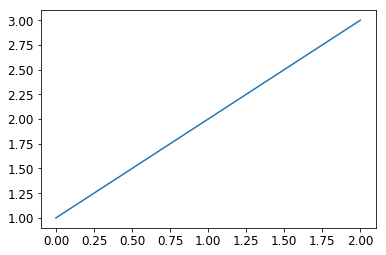

In [24]:
out = Output()
plt.figure()
with out:
        clear_output(wait=True)
        plt.plot([1,2,3])
        time.sleep(1)